#**Tutorial E91 protocol**
###**Prerequisites**
- Basic knowledge of Dirac notation and Pauli operations.
- Basic knowledge of Python (Qiskit).




In [ ]:
#Install Qiskit library
!pip install qiskit-aer
!pip install pylatexenc
!pip install matplotlib

In [ ]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import qiskit.visualization
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
import qiskit
import qiskit_aer

print("Qiskit Terra version:", qiskit.__version__)
print("Qiskit Aer version:", qiskit_aer.__version__)

Qiskit Terra version: 2.3.0
Qiskit Aer version: 0.17.2


##**E91 Protocol Scheme - Code and Theory**

This protocol was proposed by Artur Ekert in 1991 and belongs to the field of Quantum Key Distribution (QKD). It involves two parties, Alice and Bob, who want to share a secret key. An entangled photon source sends pairs of entangled photons to Alice and Bob in order to generate this shared key.

After the photons are received, a small subset of the measured bits is used to create the shared key, while a larger subset is used to evaluate Bell’s inequalities. This test allows Alice and Bob to detect the presence of an eavesdropper.

Unlike classical cryptography, which includes key generation, encryption, and decryption algorithms, this protocol focuses only on generating a secure key.

For example, Alice and Bob can use the generated key with a symmetric encryption system such as 3DES, AES, or the one-time pad.

**Example one-time pad:** $k \oplus m = c$

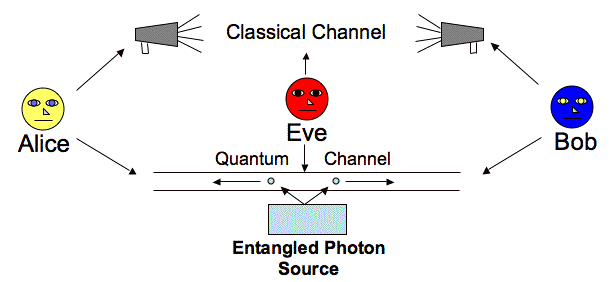

*Note: Our implementation si not secure in practice and the channel cannot be secure, they are focused on detect the presence of eavesdropping on the process of key generation.*

###**1. Quantum Entanglement**


The E91 protocol is based on the application of quantum entanglement between two qubits. The qubits can be located to a large distance between them and remain the quantum entanglement. The measurement of one qubit immediately breaks the entanglement. The quantum circuit must generate a [Bell State](https://quantum.cloud.ibm.com/learning/en/courses/basics-of-quantum-information/multiple-systems/quantum-information), therefore we have four two-qubits state to choose.

In our case, the Bell state is the following:
$$
|\psi_s^{(-)}\rangle = \frac{1}{\sqrt{2}}\big( |01\rangle - |10\rangle \big)
$$

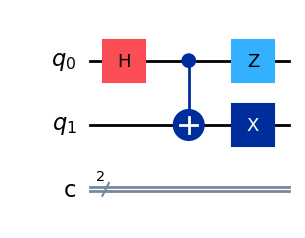

In [ ]:
# Function to create singlet state Ψ⁻
def create_singlet():
    qreg = QuantumRegister(2, name="q")
    creg = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(qreg, creg)
    qc.h(qreg[0])            # |+0>
    qc.cx(qreg[0], qreg[1])  # |Φ+>
    qc.z(qreg[0])            # |Φ->
    qc.x(qreg[1])            # |Ψ->
    return qc, qreg, creg

#Simple Example
qc_, qreg_, creg_ = create_singlet()
qc_.draw("mpl")

The operations of the previous code are represented as following:

**1.** Two qubits initialized on state 0:

$$
|00\rangle
$$

**2.** To apply a Hadamard gate to the first qubit to get the quantum superposition.:

$$
H|0\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)
$$



**3.** To apply a CNOT gate, being $q_0$ the control qubit and $q_1$ the target qubit, creating the entanglement between them:

$$
\frac{1}{\sqrt{2}}\left( |00\rangle + |10\rangle \right)
\overset{\mathrm{CNOT}_{0,1}}{=}
\frac{1}{\sqrt{2}}\left( |00\rangle + |11\rangle \right)
= |\Phi^+\rangle
$$
The system is now in a non-separable (entangled) superposition.

**4.** To apply a Z gate to change the phase:

$$
|\Phi^+\rangle
\overset{Z_0}{=}
\frac{1}{\sqrt{2}}\left( |00\rangle - |11\rangle \right)
= |\Phi^-\rangle
$$

**5.** To apply the NOT gate (X) to qubit 2, changing the state value:

$$
|\Phi^-\rangle
\overset{X_1}{=}
\frac{1}{\sqrt{2}}\left( |01\rangle - |10\rangle \right)
= |\Psi^-\rangle
$$

[Here](https://quantum.cloud.ibm.com/composer?initial=N4IgjghgzgtiBcIDyAFAogOQIoEEDKAsgAQBMAdAAwDcAOgHYCWdAxgDYCuAJgKZE3jdWDAEYBGMk2b9ademABO3AOZEwAbRIBdGc0UrmagCzb6AC1VqKJlgA8LVgDQXR1gF73rd9S5kgHIOggYbgQQAFU6ABcGSNZuTiJmBnlmdhiQAF8gA) there is a best visualization using the Bloch sphere representation.

###**2. Measurement Bases**
Once Bob and Alice have the singlet state, they are responsable for measuring their respective qubits (Alice measures q0, Bob measures q1). Every party has three measurement and they will share on classical channel.

*   Alice's bases: {$a_1, a_2, a_3$}
*   Bob's bases: {$b_1, b_2, b_3$}

In our case, our values are the next:
*   Alice's bases: {$0^\circ, 90^\circ, 45^\circ\$}

*   Bob's bases: {$0^\circ, 45^\circ, -45^\circ\$}

The qubits are measured on XZ-plane, so we need to apply the angle to axis Y. The probability to measure with the same angles is $\frac{1}{3}$.

In [ ]:
alice_angles = [0, np.pi/2, np.pi/4]
bob_angles   = [0, np.pi/4, -np.pi/4]

# Measure qubit in a rotated basis
def measure_in_basis(qc, qubit, cbit, angle):
    qc.ry(-angle, qubit)
    qc.measure(qubit, cbit)

For entangled qubits, when are measured on different angles, the results are uncorrelated (e.g. $\frac{\pi}{4}, \frac{\pi}{2}$).

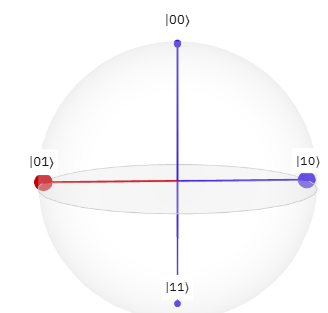

If the angles applied are the same, the results will be correlated to the previous Bell State chosen.
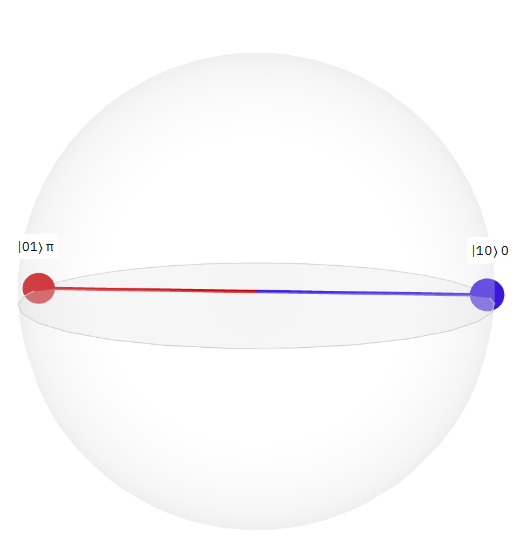

###**3. Active Evesdropping**

In [ ]:
#You can modify this variabble to active Eve's presence
evesdropping = True

#How the angles are shared on classical channel, Eve has access to the Alice's and Bob's angles.
eve_angles = [0, math.pi/4, math.pi/2, -math.pi/4]

###**3. Create the shared key**

This simulation will show how E91 protocol works with a small number of photons (100 shots) and construct a shared key.

In [ ]:
# Initialize global parameters
shots = 100
alice_results = []
bob_results = []
shared_key = []

#Create the simulator
sim = AerSimulator()


for _ in range(shots):

   ########### Step 1: Create singlet state ###########

   qc, qreg, creg = create_singlet()

   ########### Step 1: Create singlet state ###########

   ########### Evesdropping (Optional) ###########

   if evesdropping:
    #Eve intercepts Alice's qubits
      eve_choice = random.choice(eve_angles)
      measure_in_basis(qc, qreg[0], creg[0], eve_choice)
      qc.reset(qreg[0])
      with qc.if_test((creg[0], 1)):
        qc.x(qreg[0])


   ########### Evesdropping (Optional) ###########

   ########### Step 2: Measurement bases ###########

   # Randomly choose measurement bases
   a_choice = random.choice(alice_angles)
   b_choice = random.choice(bob_angles)

   # Alice measures the qubit 0 and Bob measures the qubit 1
   measure_in_basis(qc, qreg[0], creg[0], a_choice)
   measure_in_basis(qc, qreg[1], creg[1], b_choice)

   ########### Step 2: Measurement bases ###########

   # Transpile and run
   t_qc = transpile(qc, sim)
   job = sim.run(t_qc, shots=1)
   result = job.result()
   counts = result.get_counts()

   #We get the bit values
   bits = list(counts.keys())[0]
   a_bit = int(bits[1])
   b_bit = int(bits[0])

   # Encode keys
   alice_encoded = a_bit
   bob_encoded   = b_bit

   #Append the results
   alice_results.append((a_choice, alice_encoded))
   bob_results.append((b_choice, bob_encoded))

    # Keep key if bases are "compatible"
   if a_choice == b_choice:
       shared_key.append(alice_encoded)

Alice results: [(1.5707963267948966, 0), (0, 0), (0, 1), (1.5707963267948966, 0), (0, 0), (1.5707963267948966, 0), (1.5707963267948966, 0), (0, 1), (0, 1), (0.7853981633974483, 1), (0.7853981633974483, 1), (0, 1), (0, 1), (0, 0), (0, 0), (0.7853981633974483, 0), (0, 1), (1.5707963267948966, 1), (0.7853981633974483, 0), (1.5707963267948966, 0), (0.7853981633974483, 1), (0.7853981633974483, 0), (0.7853981633974483, 1), (0.7853981633974483, 0), (1.5707963267948966, 1), (0.7853981633974483, 0), (0, 0), (1.5707963267948966, 0), (1.5707963267948966, 0), (0.7853981633974483, 0), (0.7853981633974483, 1), (0, 1), (0.7853981633974483, 1), (1.5707963267948966, 1), (0, 1), (1.5707963267948966, 0), (0.7853981633974483, 1), (0.7853981633974483, 0), (0.7853981633974483, 1), (1.5707963267948966, 0), (0.7853981633974483, 1), (0.7853981633974483, 1), (0, 1), (1.5707963267948966, 1), (0, 0), (1.5707963267948966, 1), (0.7853981633974483, 0), (0.7853981633974483, 0), (0.7853981633974483, 1), (0.78539816339

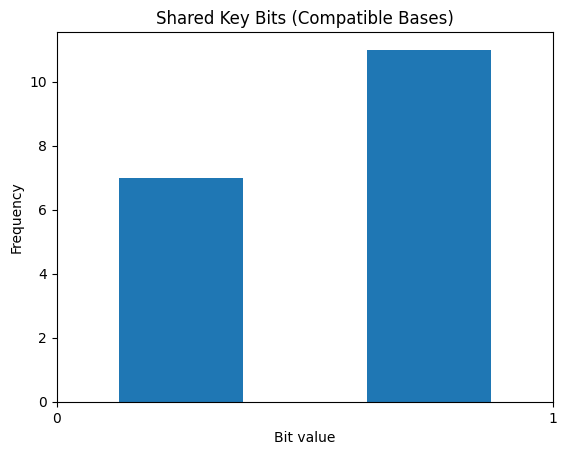

In [ ]:
# Display results
print("Alice results:", alice_results)
print("Bob results:", bob_results)
print("Shared key:", shared_key)
print("Number of key bits:", len(shared_key))

# Simple histogram of key bits
plt.hist(shared_key, bins=2, rwidth=0.5)
plt.xticks([0,1])
plt.xlabel("Bit value")
plt.ylabel("Frequency")
plt.title("Shared Key Bits (Compatible Bases)")
plt.show()

### **5. Bell inequalities: Detecting Eavesdropping**


Now Alice and Bob have to verify whether Eve is on their protocol.

#### **What is Bell's Theorem?**
[Bell's theorem](https://en.wikipedia.org/wiki/Bell%27s_theorem) shows that quantum mechanics is incompatible with local hidden-variable theories, which assume that measurement results are predetermined and no information travels faster than light.

#### **What are Bell's Inequalities?**
[Bell's inequalities](https://quantum.cloud.ibm.com/learning/en/modules/quantum-mechanics/bells-inequality-with-qiskit) are designed to test whether the correlations observed in nature can be explained by local hidden variables.

The inequality formula sees if the real world satisfies local realism, which assumes the existence of local hidden variables (features that don't belong in quantum theory) that determine the measurement outcomes.

There are two cases:

- If the correlations can be explained by local hidden variables, Bell's inequality is not violated.
- If Bell's inequality is violated, the correlations cannot be explained by local hidden variables.

###**What is the relation between Bell's inequalities and eavesdropping?**
In E91, we have the following cases:

- If Bell's inequality is violated, there is not evesdropping.
- If Bell's inequality is not violated, Eve's presence is active.


In the previous code example, we did a sample example of 100 shots to create the shared secret key. In this section, to detect evesdropping, is needed 10000 shots to get an accurate computation of Bell's Inequalities.

The bell's inequalities formula is the following:
$$ S = E(a,b) + E(a,b') + E(a',b) - E(a',b') $$ where $E$ is an estimation of bit results between Alice's Angles (a, a') and Bob's angles (b, b').

- If $S \le 2$, then Bell's inequalities are not violated.
- If $2 \le S \le 2 \sqrt{2}$, the equation is violated.
- Otherwise, is not physically possible.

In [ ]:
# initialize list of circuits and indexes of a matrix (labels)
circuits = []
labels = []
shots_statistics = 10000
for i, a in enumerate(alice_angles):
    for j, b in enumerate(bob_angles):

        ########### Step 1: Create singlet state ###########
        qc, qreg , creg = create_singlet()
        ########### Step 1: Create singlet state ###########

        ########### Evesdropping (Optional) ###########
        if evesdropping:
          #Eve intercepts Alice's qubits
          eve_choice = random.choice(eve_angles)
          measure_in_basis(qc, qreg[0], creg[0], eve_choice)
          qc.reset(qreg[0])
        ########### Evesdropping (Optional) ###########

        ########### Step 2: Measurement bases ###########
        measure_in_basis(qc, qreg[0], creg[0], a)
        measure_in_basis(qc, qreg[1], creg[1], b)
        ########### Step 2: Measurement bases ###########

        #Append the circuit
        circuits.append(qc)

        #Append indexes to create a matrix where store the E inequalities values
        labels.append((i, j))

#Initiliaze simulation with 10000 shots. In this case we need a huge number of shots to get an accurate Bell's inequalities result
backend = AerSimulator()
result = backend.run(circuits, shots=shots_statistics).result()

#The matrix E where S results
E = np.zeros((3, 3))

#The matrix is full by the computations of every respective angle's correlations
for k, (i, j) in enumerate(labels):
    counts = result.get_counts(k)

    corr = 0.0

    for bits, n in counts.items():
        a_val = 1 if bits[1] == '0' else -1
        b_val = 1 if bits[0] == '0' else -1
        corr += a_val * b_val * n / shots_statistics

    E[i, j] = corr
    print(f"E(A{i},B{j}) = {corr:.3f}")

# =========================
# Compute S (CHSH)
# =========================
# The following angles will be used:
# A0 = 0
# A1 = pi/2
# B0 = pi/4
# B1 = -pi/4
#
# Indixes:
# A0 -> i=0
# A1 -> i=1
# B0 -> j=1
# B1 -> j=2

S = (
    E[0, 1]   # E(A0, B0)
  + E[0, 2]   # E(A0, B1)
  + E[1, 1]   # E(A1, B0)
  - E[1, 2]   # E(A1, B1)
)

print("\nCHSH:")
print(f"S = {S:.3f}")
print(f"|S| = {abs(S):.3f}")

E(A0,B0) = 0.009
E(A0,B1) = 0.015
E(A0,B2) = 0.002
E(A1,B0) = 0.005
E(A1,B1) = 0.004
E(A1,B2) = 0.000
E(A2,B0) = -0.011
E(A2,B1) = -0.002
E(A2,B2) = 0.005

CHSH:
S = 0.020
|S| = 0.020


# **References**

https://en.wikipedia.org/wiki/CHSH_inequality

https://mpl.mpg.de/fileadmin/user_upload/Chekhova_Research_Group/Lecture_4_12.pdf